In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [7]:
G = FullyConnected([prior_size, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [8]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [9]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [10]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z))
        true_pred = D(data)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z))
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [11]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z))
            true_pred = D(data)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.7000, D: 0.6846
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 1.4138, D: 0.2542
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.8342, D: 0.4724


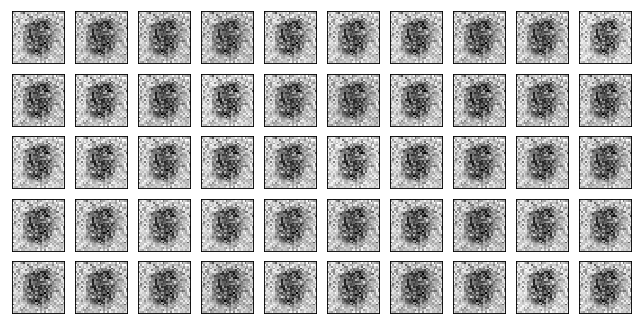

Test losses. G: 0.7665, D: 0.4241
Train Epoch: 2 [0/50000 (0%)]	Losses G: 1.6639, D: 0.5112
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 1.7423, D: 0.4181
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 1.7905, D: 0.6635


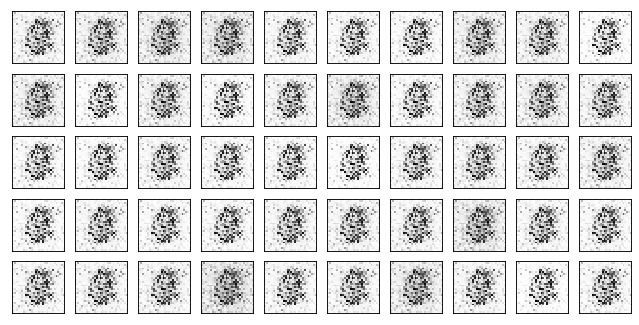

Test losses. G: 0.8062, D: 0.5993
Train Epoch: 3 [0/50000 (0%)]	Losses G: 1.8552, D: 0.6671
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 0.6132, D: 1.3216
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 2.3402, D: 0.2510


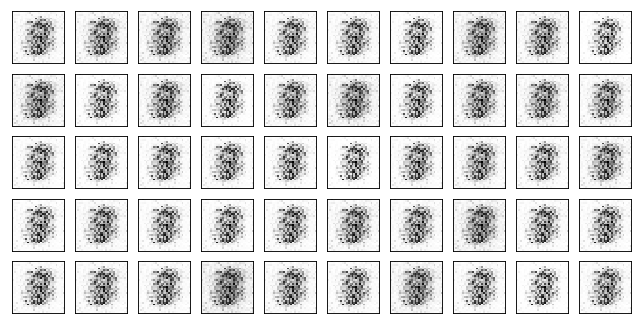

Test losses. G: 1.5548, D: 0.2459
Train Epoch: 4 [0/50000 (0%)]	Losses G: 2.2081, D: 0.2760
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 2.1335, D: 0.2343
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 1.6423, D: 0.6582


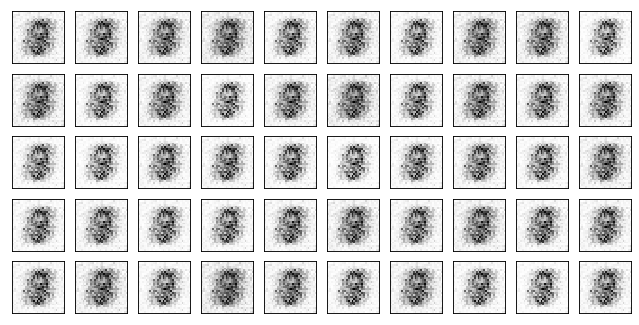

Test losses. G: 0.9884, D: 0.4931
Train Epoch: 5 [0/50000 (0%)]	Losses G: 1.8607, D: 0.6295
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 1.3194, D: 0.6978
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 1.1945, D: 0.4417


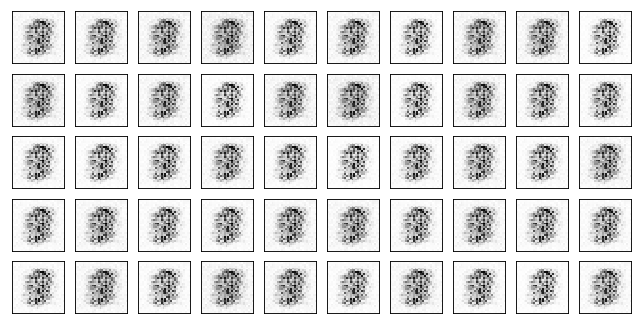

Test losses. G: 1.0994, D: 0.3889
Train Epoch: 6 [0/50000 (0%)]	Losses G: 1.1796, D: 0.4322
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 0.7914, D: 0.7479
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 1.9126, D: 0.4065


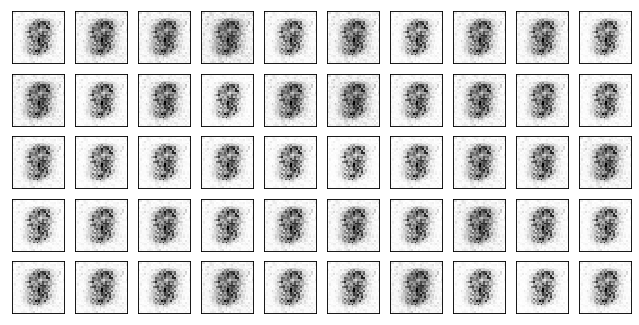

Test losses. G: 1.5547, D: 0.2737
Train Epoch: 7 [0/50000 (0%)]	Losses G: 2.0385, D: 0.3232
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 2.2143, D: 0.2046
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 2.2067, D: 0.3651


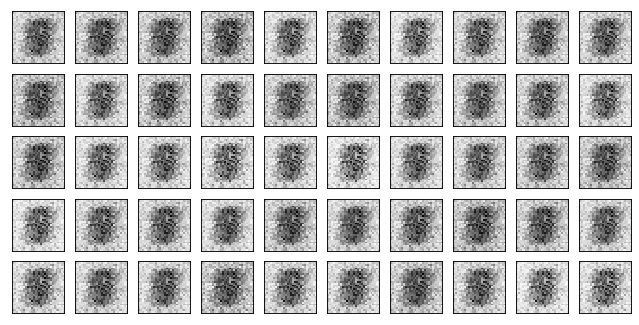

Test losses. G: 1.4511, D: 0.2146
Train Epoch: 8 [0/50000 (0%)]	Losses G: 2.1869, D: 0.2957
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 2.9530, D: 0.2431
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 3.2549, D: 0.1155


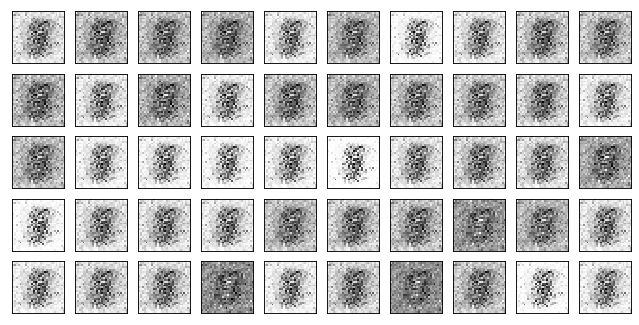

Test losses. G: 2.8683, D: 0.0428
Train Epoch: 9 [0/50000 (0%)]	Losses G: 3.1795, D: 0.0957
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 3.4366, D: 0.1533
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.8636, D: 0.0863


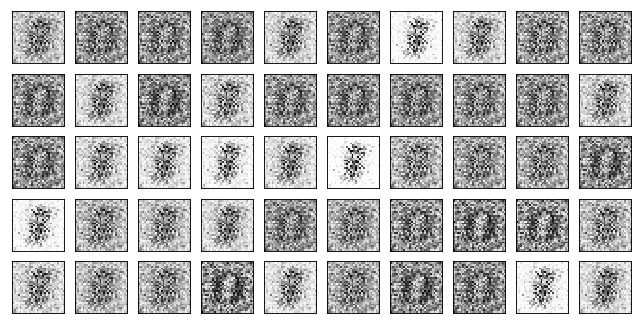

Test losses. G: 3.0273, D: 0.0358
Train Epoch: 10 [0/50000 (0%)]	Losses G: 3.7147, D: 0.0869
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 3.7751, D: 0.1668
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 4.7838, D: 0.0847


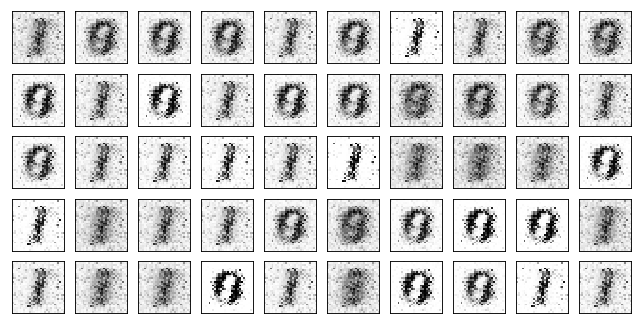

Test losses. G: 4.0484, D: 0.0275
Train Epoch: 11 [0/50000 (0%)]	Losses G: 4.5004, D: 0.0871
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 4.4163, D: 0.1234
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 5.1256, D: 0.1302


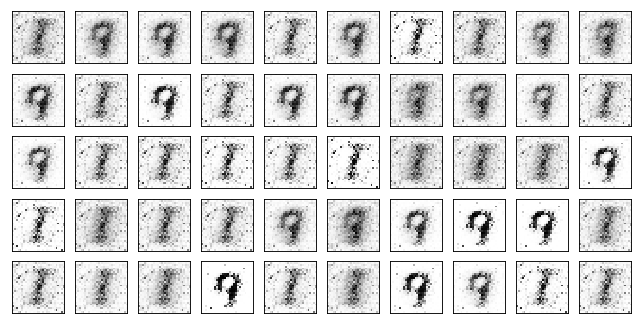

Test losses. G: 4.7311, D: 0.0440
Train Epoch: 12 [0/50000 (0%)]	Losses G: 4.6405, D: 0.1317
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 5.3964, D: 0.0454
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 4.4218, D: 0.0968


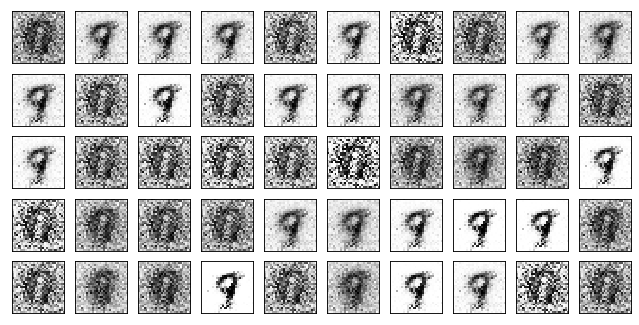

Test losses. G: 3.3392, D: 0.0468
Train Epoch: 13 [0/50000 (0%)]	Losses G: 4.0972, D: 0.1400
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 5.3152, D: 0.0764
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 4.7808, D: 0.0880


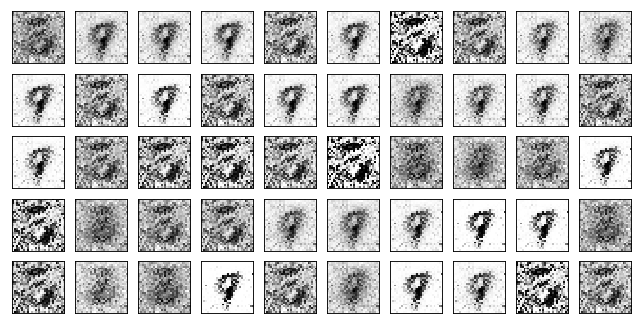

Test losses. G: 3.8452, D: 0.0318
Train Epoch: 14 [0/50000 (0%)]	Losses G: 4.4466, D: 0.0674
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 5.7825, D: 0.0666
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 5.7493, D: 0.0420


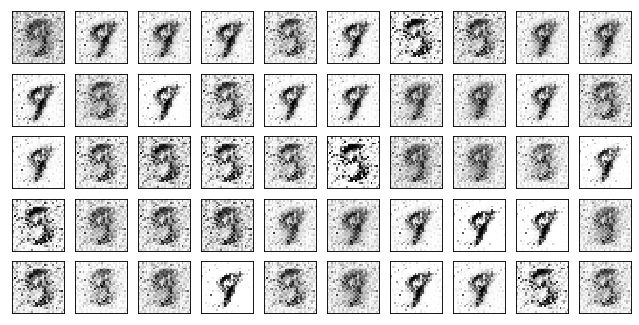

Test losses. G: 5.0610, D: 0.0091
Train Epoch: 15 [0/50000 (0%)]	Losses G: 5.7416, D: 0.0493
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 5.5949, D: 0.0574
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 5.9011, D: 0.0627


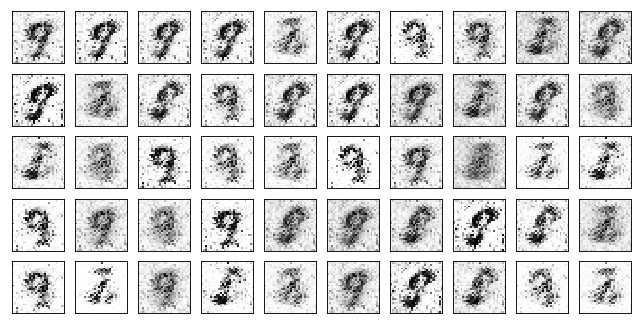

Test losses. G: 5.1184, D: 0.0128
Train Epoch: 16 [0/50000 (0%)]	Losses G: 5.8568, D: 0.0772
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 6.2060, D: 0.0588
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 4.7176, D: 0.0627


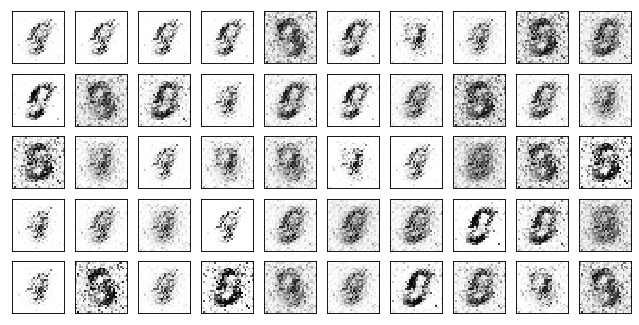

Test losses. G: 4.0611, D: 0.0174
Train Epoch: 17 [0/50000 (0%)]	Losses G: 5.3988, D: 0.0767
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 5.4511, D: 0.0468
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 5.2268, D: 0.0981


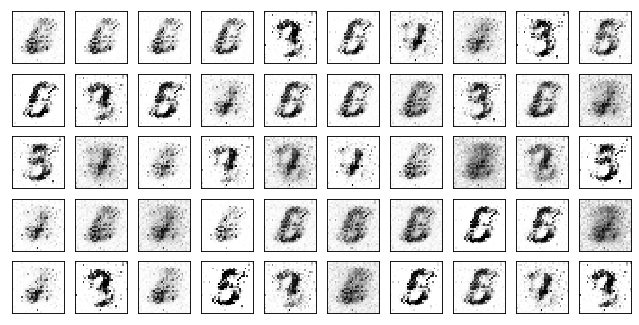

Test losses. G: 4.3740, D: 0.0274
Train Epoch: 18 [0/50000 (0%)]	Losses G: 4.6820, D: 0.1223
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 5.1156, D: 0.1340
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 5.3940, D: 0.1592


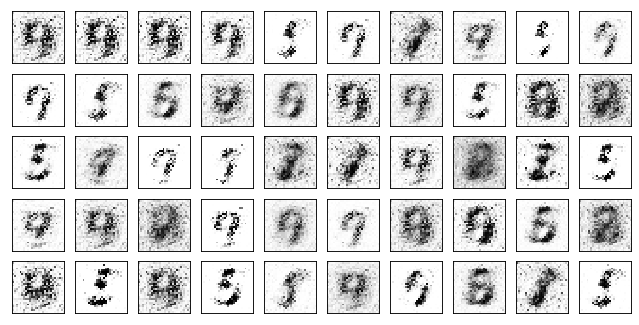

Test losses. G: 4.2096, D: 0.0531
Train Epoch: 19 [0/50000 (0%)]	Losses G: 4.9267, D: 0.1134
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 4.2643, D: 0.1206
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 6.0406, D: 0.0688


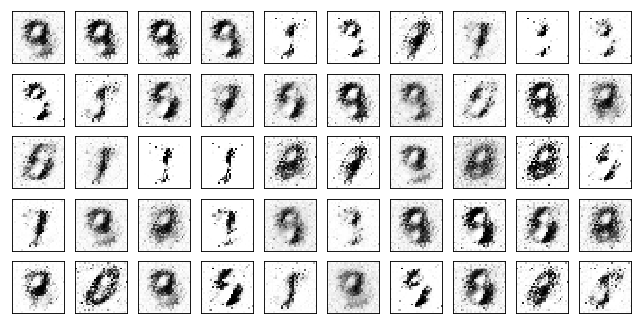

Test losses. G: 5.2188, D: 0.0173
Train Epoch: 20 [0/50000 (0%)]	Losses G: 6.2022, D: 0.0520
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 4.3366, D: 0.1147
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 5.6230, D: 0.0914


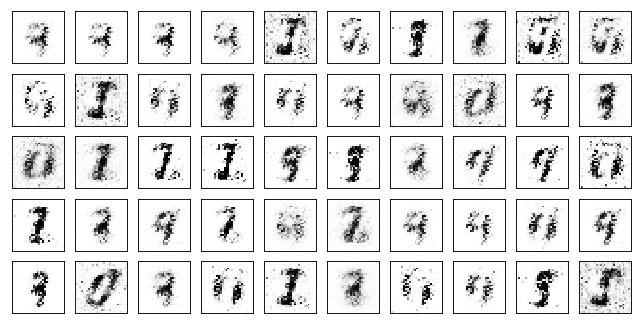

Test losses. G: 5.0746, D: 0.0621
Train Epoch: 21 [0/50000 (0%)]	Losses G: 5.3227, D: 0.1348
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 4.5340, D: 0.1064
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 4.7941, D: 0.1109


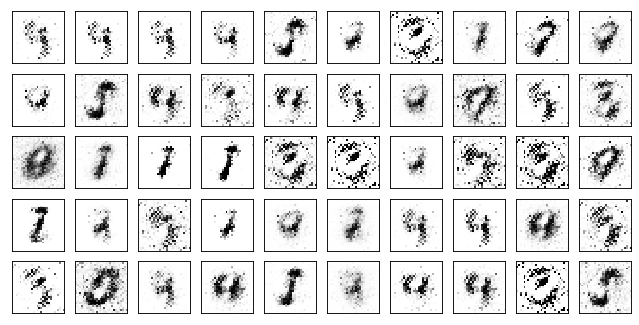

Test losses. G: 3.9643, D: 0.0434
Train Epoch: 22 [0/50000 (0%)]	Losses G: 4.5097, D: 0.1250
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 5.3735, D: 0.0733
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 5.0314, D: 0.0607


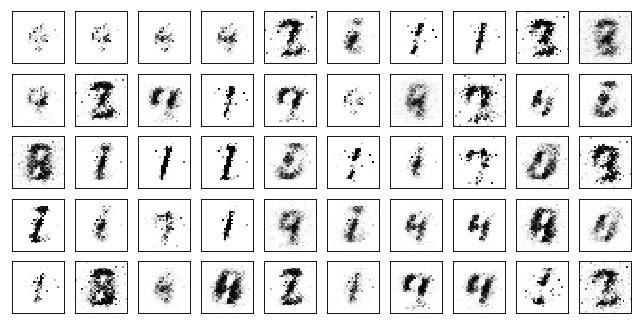

Test losses. G: 4.5570, D: 0.0259
Train Epoch: 23 [0/50000 (0%)]	Losses G: 4.8635, D: 0.0884
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 6.0369, D: 0.0653
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 4.6942, D: 0.1165


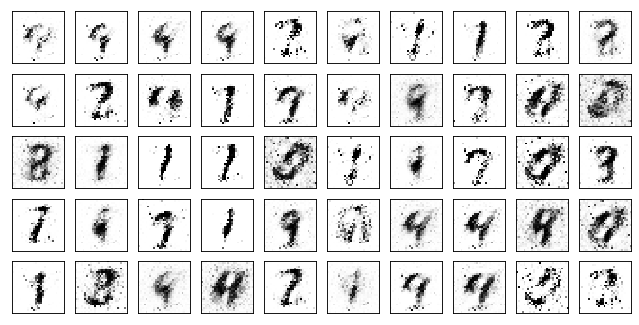

Test losses. G: 4.3968, D: 0.0234
Train Epoch: 24 [0/50000 (0%)]	Losses G: 5.9591, D: 0.0637
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 4.4469, D: 0.0848
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 5.9400, D: 0.0891


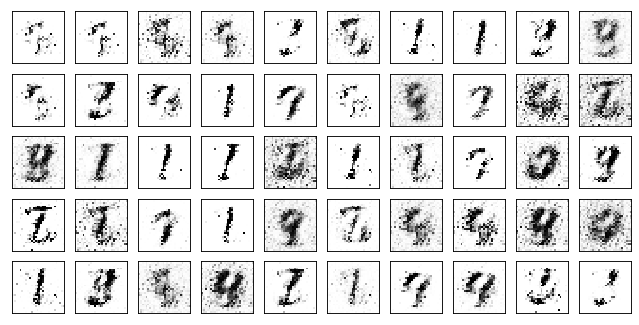

Test losses. G: 5.0675, D: 0.0380
Train Epoch: 25 [0/50000 (0%)]	Losses G: 4.4553, D: 0.0967
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 5.2404, D: 0.0888
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 5.9671, D: 0.1232


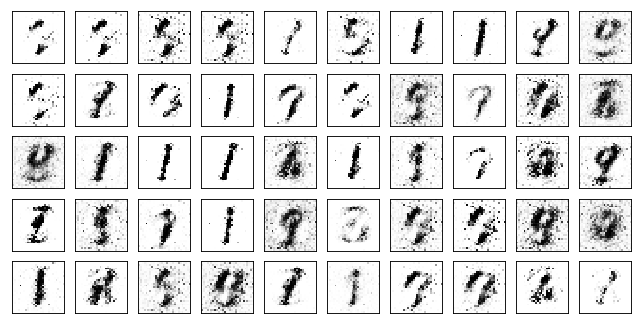

Test losses. G: 5.1055, D: 0.1192
Train Epoch: 26 [0/50000 (0%)]	Losses G: 4.1106, D: 0.2484
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 5.1285, D: 0.0856
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 3.6692, D: 0.1251


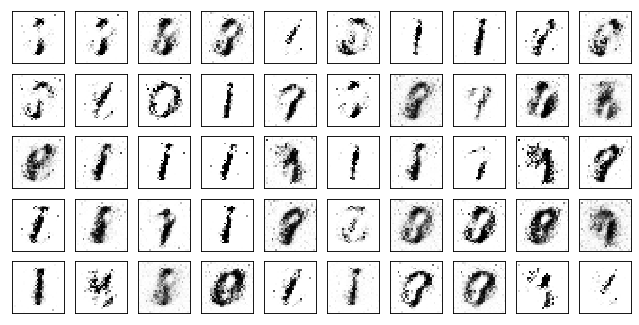

Test losses. G: 3.0626, D: 0.0588
Train Epoch: 27 [0/50000 (0%)]	Losses G: 4.9585, D: 0.1520
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 4.2565, D: 0.0858
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 4.4772, D: 0.1838


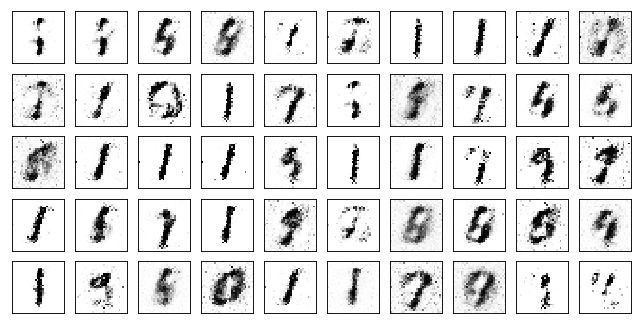

Test losses. G: 3.8118, D: 0.0706
Train Epoch: 28 [0/50000 (0%)]	Losses G: 4.4524, D: 0.1679
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 4.8193, D: 0.0907
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 3.8276, D: 0.0961


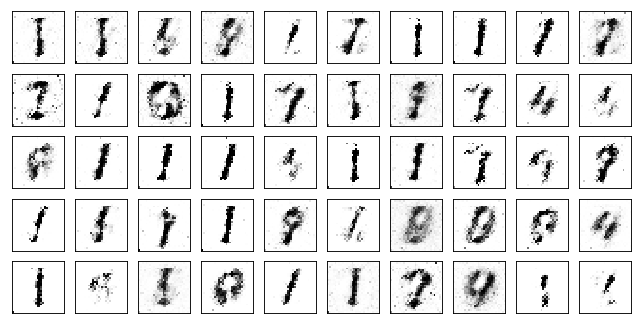

Test losses. G: 3.4117, D: 0.0553
Train Epoch: 29 [0/50000 (0%)]	Losses G: 4.3419, D: 0.0996
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 3.6391, D: 0.1696
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 4.3134, D: 0.1340


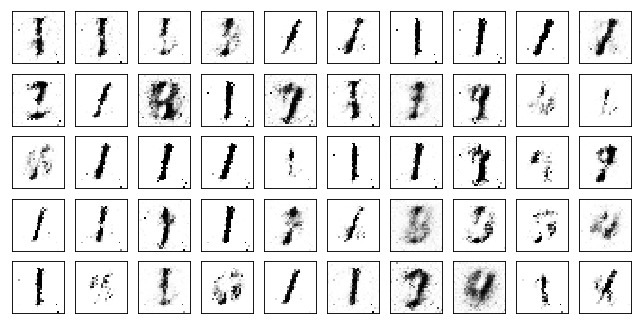

Test losses. G: 4.0631, D: 0.0583
Train Epoch: 30 [0/50000 (0%)]	Losses G: 4.9176, D: 0.0955
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 3.4102, D: 0.1119
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 3.6515, D: 0.1665


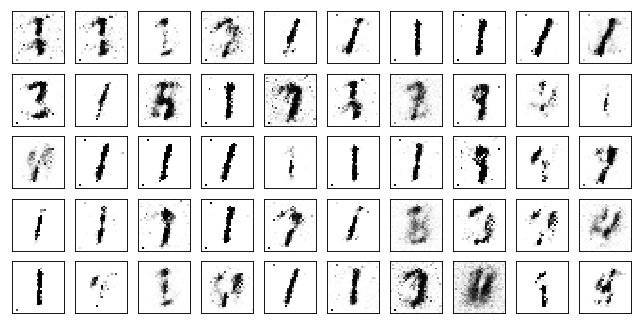

Test losses. G: 3.2908, D: 0.0785


In [12]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)